# Train

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [111]:
df = pd.read_csv('./s_h_p.csv')

ori_df = df

df.head()

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,CONVENIENCE,WASHING,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,Old,sector,divisition,city
0,테라156,OPST,202103,EE,31.70,34.73,31.0,249,NaN,NaN,...,12,4,1,3,0,2,2021,가락동,송파구,서울시
1,아키죤,APT,200211,EE,86.83,86.83,86.0,0,89000.0,96000.0,...,20,6,12,3,0,1,2002,가락동,송파구,서울시
2,강남팰리스,OPST,202102,EE,29.23,33.19,29.0,249,30000.0,30000.0,...,34,14,13,2,0,1,2021,가락동,송파구,서울시
3,송파성원상떼빌(주상복합),APT,200606,EE,113.32,182.06,182.0,545,118000.0,200000.0,...,33,11,20,1,0,1,2006,가락동,송파구,서울시
4,가락현대TWELVE,APT,200501,EE,99.91,99.91,99.0,0,NaN,NaN,...,6,4,5,1,0,1,2005,가락동,송파구,서울시


# Select Feature & Label

In [112]:
label = 'price'
columns = ['Type', 'Dir' ,'Old', 'sector', 'divisition', 'representativeArea', 'floorAreaRatio', 'BUS', 'METRO', 'INFANT', 'PRESCHOOL', 'HOSPITAL', 'PARKING', 'MART', 'CONVENIENCE', 'BANK', 'OFFICE', 'PRI_SCHOOL', 'PUB_SCHOOL', label]


df[label] = (ori_df['minDeal'] + ori_df['maxDeal']) / 2

df = df[columns].copy()

df.dropna(inplace=True)

train_df = df

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16561 entries, 1 to 17784
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                16561 non-null  object 
 1   Dir                 16561 non-null  object 
 2   Old                 16561 non-null  int64  
 3   sector              16561 non-null  object 
 4   divisition          16561 non-null  object 
 5   representativeArea  16561 non-null  float64
 6   floorAreaRatio      16561 non-null  int64  
 7   BUS                 16561 non-null  int64  
 8   METRO               16561 non-null  int64  
 9   INFANT              16561 non-null  int64  
 10  PRESCHOOL           16561 non-null  int64  
 11  HOSPITAL            16561 non-null  int64  
 12  PARKING             16561 non-null  int64  
 13  MART                16561 non-null  int64  
 14  CONVENIENCE         16561 non-null  int64  
 15  BANK                16561 non-null  int64  
 16  OFFI

# Outlier

In [113]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 3  # 제거 범위 조절 변수
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff


train_df = remove_out(train_df, [label])

train_df[label].describe()

count     16321.000000
mean      97388.773666
std       78832.002092
min        6050.000000
25%       33250.000000
50%       80000.000000
75%      135000.000000
max      450000.000000
Name: price, dtype: float64

# Visualization

## 방향에 따른 가격

/var/folders/y8/ldvzwhm13037mvvt3p2d9n0m0000gn/T/ipykernel_31095/651298774.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


[Text(0, 20000.0, '2.00억'),
 Text(0, 40000.0, '4.00억'),
 Text(0, 60000.0, '6.00억'),
 Text(0, 80000.0, '8.00억'),
 Text(0, 100000.0, '10.00억'),
 Text(0, 120000.0, '12.00억'),
 Text(0, 140000.0, '14.00억')]

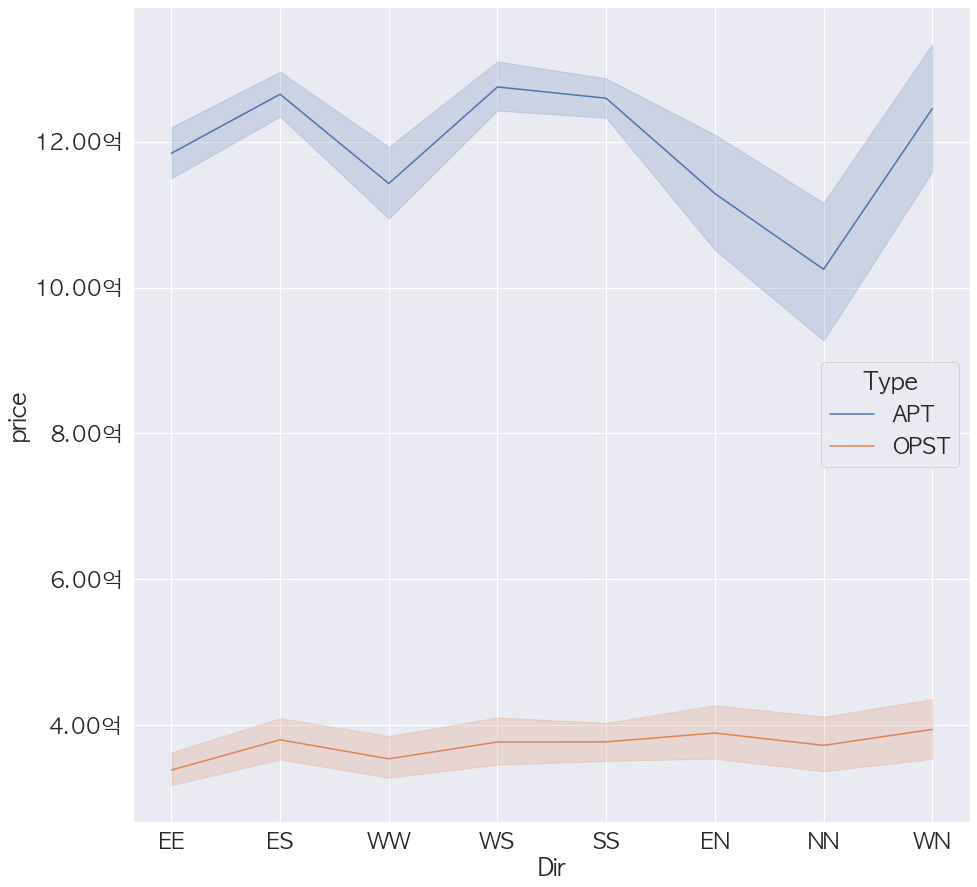

In [125]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set(font_scale = 2) 
plt.rcParams['font.family'] = 'AppleGothic'
ax = sns.lineplot(x='Dir', y = label, hue='Type' , data=train_df)
ylabels = ['{:.2f}'.format(x) + '억' for x in ax.get_yticks() / 10000]
#remove '구'
# xlabels = [x for x in ax.get_xticks()]
# ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

## 구에 따른 가격

/var/folders/y8/ldvzwhm13037mvvt3p2d9n0m0000gn/T/ipykernel_31095/1627207721.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


[Text(0, -50000.0, '-5억'),
 Text(0, 0.0, '0억'),
 Text(0, 50000.0, '5억'),
 Text(0, 100000.0, '10억'),
 Text(0, 150000.0, '15억'),
 Text(0, 200000.0, '20억'),
 Text(0, 250000.0, '25억')]

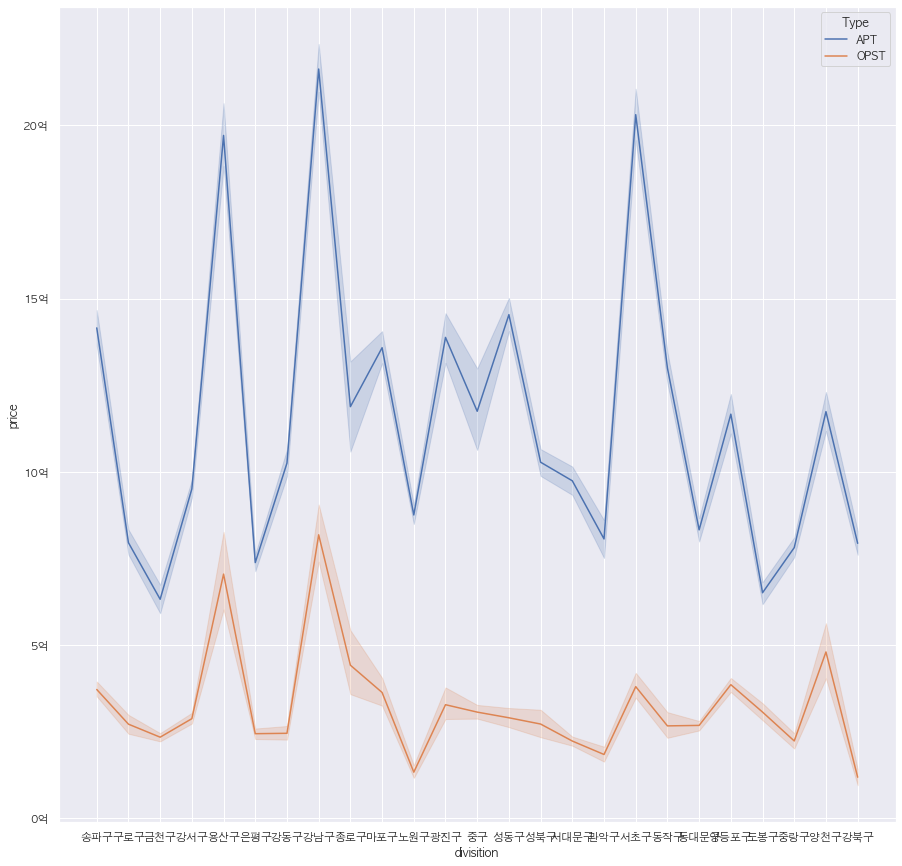

In [124]:
sns.set(font_scale = 1) 
plt.rcParams['font.family'] = 'AppleGothic'
ax = sns.lineplot(x='divisition', y = label, hue='Type' , data=train_df)
ylabels = ['{:.0f}'.format(x) + '억' for x in ax.get_yticks() / 10000]
ax.set_yticklabels(ylabels)

## 아파트 오피스텔 별 가격

/var/folders/y8/ldvzwhm13037mvvt3p2d9n0m0000gn/T/ipykernel_31095/145975249.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


[Text(0, -100000.0, '-10억'),
 Text(0, 0.0, '0억'),
 Text(0, 100000.0, '10억'),
 Text(0, 200000.0, '20억'),
 Text(0, 300000.0, '30억'),
 Text(0, 400000.0, '40억'),
 Text(0, 500000.0, '50억')]

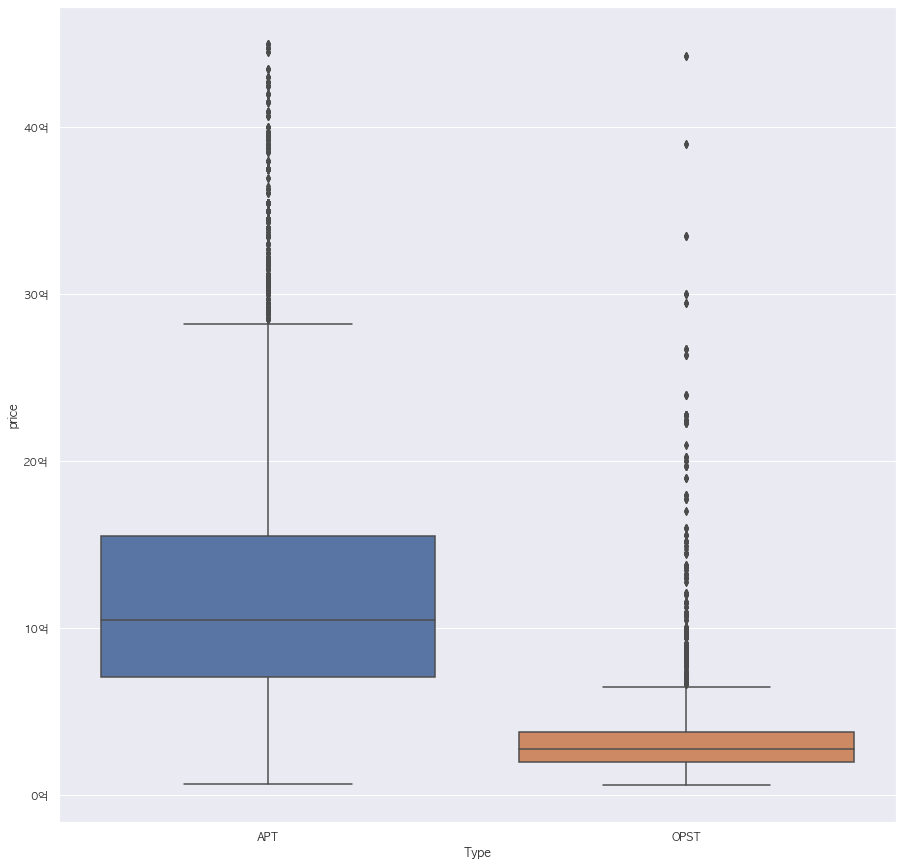

In [123]:
sns.set(font_scale = 1) 
plt.rcParams['font.family'] = 'AppleGothic'
ax = sns.boxplot(x='Type', y = label, data=train_df)
ylabels = ['{:.0f}'.format(x) + '억' for x in ax.get_yticks() / 10000]
ax.set_yticklabels(ylabels)

# Label Encoding

In [85]:
# from sklearn.preprocessing import LabelEncoder

# def labelencoder(df):                               
#     encoders = {}
#     i = 0
#     for c in df.columns:     
#         encoders[i] = None
#         if df[c].dtype=='object': 
#             df[c] = df[c].fillna('N')
#             lbl = LabelEncoder()
#             lbl.fit(list(df[c].values))
#             df[c] = lbl.transform(df[c].values)
#             encoders[i] = lbl
#         i += 1
#     return df, encoders

# train_df, encoder_lbl = labelencoder(train_df)

# train_df

# One-Hot Encoding

In [86]:
from sklearn.preprocessing import OneHotEncoder

one_hot_col = ['Type', 'Dir', 'Old','sector', 'divisition']

def encode_one_hot(df, col_name):
    ohe = OneHotEncoder(sparse=False)
    trained = ohe.fit_transform(df[[col_name]].copy())
    res_df = pd.DataFrame(trained, columns=['%s_%s' % (col_name, col) for col in ohe.categories_[0]]).astype(int)
    res_df.reset_index(drop=True, inplace=True)
    return ohe, res_df
    
one_hot_df = df[one_hot_col]    

temp_df = df.drop(labels=one_hot_col, axis=1)
temp_df.reset_index(drop=True, inplace=True)

encoders_hot = []
encoded_dfs = []

for col in one_hot_col:
    ohe, p_df = encode_one_hot(one_hot_df, col)
    encoded_dfs.append(p_df)
    encoders_hot.append(ohe)
    
encoded_dfs.append(temp_df)

train_df = pd.concat(encoded_dfs, axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16561 entries, 0 to 16560
Columns: 419 entries, Type_APT to price
dtypes: float64(2), int64(417)
memory usage: 52.9 MB


In [87]:
train_df.head()

,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
0,1,0,1,0,0,0,0,0,0,0,...,1,0,14,2,20,12,3,0,1,92500.0
1,0,1,1,0,0,0,0,0,0,0,...,0,1,11,4,34,13,2,0,1,30000.0
2,1,0,1,0,0,0,0,0,0,0,...,1,1,14,2,33,20,1,0,1,159000.0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,8,1,9,9,1,0,1,306750.0
4,1,0,1,0,0,0,0,0,0,0,...,1,0,7,3,24,18,1,0,2,227500.0


In [88]:
train_df.describe()

,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
count,16561.000000,16561.000000,16561.000000,16561.00000,16561.000000,16561.000000,16561.000000,16561.000000,16561.000000,16561.000000,...,16561.000000,16561.000000,16561.000000,16561.000000,16561.000000,16561.000000,16561.000000,16561.000000,16561.000000,1.656100e+04
mean,0.705694,0.294306,0.159894,0.05513,0.183745,0.048185,0.261880,0.045649,0.156573,0.088944,...,1.491999,0.592114,12.229153,1.982851,21.112433,8.128193,3.273474,0.247328,0.781052,1.056481e+05
std,0.455744,0.455744,0.366519,0.22824,0.387288,0.214164,0.439671,0.208730,0.363408,0.284671,...,1.271843,1.744760,13.817796,1.559743,12.101430,6.879426,2.624651,0.502226,0.734259,1.080250e+05
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.050000e+03
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,1.000000,12.000000,4.000000,1.000000,0.000000,0.000000,3.350000e+04
50%,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,8.000000,2.000000,19.000000,7.000000,3.000000,0.000000,1.000000,8.100000e+04
75%,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,16.000000,3.000000,28.000000,10.000000,4.000000,0.000000,1.000000,1.380000e+05
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8.000000,30.000000,129.000000,10.000000,80.000000,91.000000,20.000000,3.000000,4.000000,1.450145e+06


# To Binominal

In [89]:
binomial_header = ['BUS', 'METRO', 'INFANT', 'PRESCHOOL', 'HOSPITAL', 'PARKING', 'MART', 'CONVENIENCE', 'BANK', 'OFFICE', 'PRI_SCHOOL', 'PUB_SCHOOL']

for head in binomial_header:
    train_df.loc[:,head] = train_df[head].apply(lambda x : 1 if x > 0 else 0)

train_df


,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
0,1,0,1,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,0,1,92500.0
1,0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,0,1,30000.0
2,1,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,159000.0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0,1,306750.0
4,1,0,1,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,0,1,227500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16556,0,1,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,0,1,16250.0
16557,1,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,202500.0
16558,1,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,0,1,25500.0
16559,0,1,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,0,1,22000.0


# Scaler

In [91]:
# from sklearn.preprocessing import MinMaxScaler as Scaler

# def scale(df, col):
#     scaler = Scaler()
#     scaler.fit(df[[col]])
#     train_data_robustScaled = scaler.transform(df[[col]])
#     return pd.DataFrame(data=train_data_robustScaled, columns=[col]), scaler
    
# repre_df, repre_scaler = scale(train_df, 'representativeArea')
# floor_df, floor_scaler = scale(train_df, 'floorAreaRatio')

# train_df['representativeArea'] = repre_df
# train_df['floorAreaRatio'] = floor_df

# train_df

# K-Fold

In [92]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

def get_rsme_score(model, kf, X, y):
    X = X.values
    rsme_history = []
    for train_index, test_index in tqdm(kf.split(X)):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rsme_history.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return rsme_history
                            
                            
X = train_df.drop(label, axis=1)
Y = train_df[label]

kf = KFold(n_splits = 5, shuffle = True, random_state = 14)

X.head()

,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,INFANT,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL
0,1,0,1,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1
1,0,1,1,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,1
2,1,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
3,1,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,0,1
4,1,0,1,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1


## Decision Tree

In [93]:
from sklearn.tree import DecisionTreeRegressor

rmse_history = get_rsme_score(DecisionTreeRegressor(), kf, X, Y)

for i, v in enumerate(rmse_history):
    print(i, 'RMSE:', v)
print('AVG:', np.mean(rmse_history))
print('MIN:', np.min(rmse_history))
print('MAX:', np.max(rmse_history))

0it [00:00, ?it/s]

0 RMSE: 15008.889726243851
1 RMSE: 15592.268800237123
2 RMSE: 13868.613586088737
3 RMSE: 16980.505100555034
4 RMSE: 13981.720735586918
AVG: 15086.399589742334
MIN: 13868.613586088737
MAX: 16980.505100555034


## Random Forest

In [94]:
from sklearn.ensemble import RandomForestRegressor

rmse_history = get_rsme_score(RandomForestRegressor(n_estimators = 30, random_state = 20), kf, X, Y)

for i, v in enumerate(rmse_history):
    print(i, 'RMSE:', v)
print('AVG:', np.mean(rmse_history))
print('MIN:', np.min(rmse_history))
print('MAX:', np.max(rmse_history))

0it [00:00, ?it/s]

0 RMSE: 13808.805849962117
1 RMSE: 13770.008395243853
2 RMSE: 13591.94961368703
3 RMSE: 14854.435580118432
4 RMSE: 13678.69641468315
AVG: 13940.779170738915
MIN: 13591.94961368703
MAX: 14854.435580118432


## Linear

In [95]:
from sklearn.linear_model import LinearRegression

rmse_history = get_rsme_score(LinearRegression(), kf, X, Y)

for i, v in enumerate(rmse_history):
    print(i, 'RMSE:', v)
print('AVG:', np.mean(rmse_history))
print('MIN:', np.min(rmse_history))
print('MAX:', np.max(rmse_history))

0it [00:00, ?it/s]

0 RMSE: 36261.80074428656
1 RMSE: 33987.36511615955
2 RMSE: 36327.34477781212
3 RMSE: 36041.21256198798
4 RMSE: 35536.30616897283
AVG: 35630.80587384381
MIN: 33987.36511615955
MAX: 36327.34477781212


## Predict

In [96]:
def encode_lbl(value, encoder, delta = 0):
    for i in range(len(value)):
        if i + delta < 0 : continue
        
        if encoder[i + delta] != None:
            value[i] = encoder[i + delta].transform([value[i]])[0]
    return value

In [99]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

model = RandomForestRegressor(n_estimators = 30, random_state = 20)

model.fit(x_train, y_train)

pred = model.predict(x_test)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

representativeArea 0.5563
divisition_강남구 0.0778
divisition_서초구 0.0436
floorAreaRatio 0.0328
Type_APT 0.0241
Type_OPST 0.0225
divisition_용산구 0.0142
sector_여의도동 0.0113
divisition_송파구 0.0085
divisition_성동구 0.0073
Old_2018 0.0068
divisition_마포구 0.0064
sector_잠원동 0.0057
Old_2020 0.0051
PUB_SCHOOL 0.0050
divisition_광진구 0.0050
sector_한남동 0.0043
sector_잠실동 0.0042
METRO 0.0042
HOSPITAL 0.0042
Old_2015 0.0040
Old_2006 0.0039
sector_청담동 0.0038
sector_논현동 0.0037
divisition_동작구 0.0037
Old_2004 0.0037
Old_2021 0.0036
Old_2017 0.0033
PRI_SCHOOL 0.0033
sector_신정동 0.0030
Old_2012 0.0029
sector_압구정동 0.0029
MART 0.0028
sector_한강로2가 0.0028
Old_2003 0.0026
sector_목동 0.0026
Old_2022 0.0025
sector_이촌동 0.0025
Old_2016 0.0024
PRESCHOOL 0.0024
divisition_영등포구 0.0022
OFFICE 0.0022
Old_2013 0.0022
Old_2014 0.0022
Old_2019 0.0019
sector_대치동 0.0018
sector_흑석동 0.0017
Old_2007 0.0016
Old_2011 0.0016
Old_2008 0.0016
divisition_동대문구 0.0014
sector_개포동 0.0014
Old_1987 0.0014
divisition_중구 0.0014
sector_삼성동 0.0014
sector_

## Important

In [100]:
pair_item = []
for i, item in enumerate(X.columns):
    pair_item.append((item, float(model.feature_importances_[i])))

pair_item = sorted(pair_item, key=lambda item: item[1], reverse=True)

for k, v in pair_item:
    print(k, "%.4f" % v)

representativeArea 0.5563
divisition_강남구 0.0778
divisition_서초구 0.0436
floorAreaRatio 0.0328
Type_APT 0.0241
Type_OPST 0.0225
divisition_용산구 0.0142
sector_여의도동 0.0113
divisition_송파구 0.0085
divisition_성동구 0.0073
Old_2018 0.0068
divisition_마포구 0.0064
sector_잠원동 0.0057
Old_2020 0.0051
PUB_SCHOOL 0.0050
divisition_광진구 0.0050
sector_한남동 0.0043
sector_잠실동 0.0042
METRO 0.0042
HOSPITAL 0.0042
Old_2015 0.0040
Old_2006 0.0039
sector_청담동 0.0038
sector_논현동 0.0037
divisition_동작구 0.0037
Old_2004 0.0037
Old_2021 0.0036
Old_2017 0.0033
PRI_SCHOOL 0.0033
sector_신정동 0.0030
Old_2012 0.0029
sector_압구정동 0.0029
MART 0.0028
sector_한강로2가 0.0028
Old_2003 0.0026
sector_목동 0.0026
Old_2022 0.0025
sector_이촌동 0.0025
Old_2016 0.0024
PRESCHOOL 0.0024
divisition_영등포구 0.0022
OFFICE 0.0022
Old_2013 0.0022
Old_2014 0.0022
Old_2019 0.0019
sector_대치동 0.0018
sector_흑석동 0.0017
Old_2007 0.0016
Old_2011 0.0016
Old_2008 0.0016
divisition_동대문구 0.0014
sector_개포동 0.0014
Old_1987 0.0014
divisition_중구 0.0014
sector_삼성동 0.0014
sector_

## Prediect

In [141]:
for item in X.columns:
    print(item)

Type_APT
Type_OPST
Dir_EE
Dir_EN
Dir_ES
Dir_NN
Dir_SS
Dir_WN
Dir_WS
Dir_WW
Old_1965
Old_1968
Old_1969
Old_1970
Old_1971
Old_1972
Old_1973
Old_1974
Old_1975
Old_1976
Old_1977
Old_1978
Old_1979
Old_1980
Old_1981
Old_1982
Old_1983
Old_1984
Old_1985
Old_1986
Old_1987
Old_1988
Old_1989
Old_1990
Old_1991
Old_1992
Old_1993
Old_1994
Old_1995
Old_1996
Old_1997
Old_1998
Old_1999
Old_2000
Old_2001
Old_2002
Old_2003
Old_2004
Old_2005
Old_2006
Old_2007
Old_2008
Old_2009
Old_2010
Old_2011
Old_2012
Old_2013
Old_2014
Old_2015
Old_2016
Old_2017
Old_2018
Old_2019
Old_2020
Old_2021
Old_2022
sector_가락동
sector_가리봉동
sector_가산동
sector_가양동
sector_갈월동
sector_갈현동
sector_강일동
sector_개봉동
sector_개포동
sector_거여동
sector_견지동
sector_경운동
sector_고덕동
sector_고척동
sector_공덕동
sector_공릉동
sector_공항동
sector_관수동
sector_관철동
sector_광장동
sector_광희동1가
sector_교북동
sector_구기동
sector_구로동
sector_구산동
sector_구수동
sector_구의동
sector_군자동
sector_궁동
sector_금호동1가
sector_금호동2가
sector_금호동3가
sector_금호동4가
sector_길동
sector_길음동
sector_낙원동
sector_남가좌동
sect

In [149]:
pred_value = ['APT', 'SS', 2022, '성산동', '마포구', 103, 237, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

#금천구(시흥동, 가산동), 도봉구(쌍문동)

#마포(성산)

#강남구(개포동, 대치동), 용산(보광), 서초구(서초동)

value = []
#Label Encoder 
# value.extend(encode_lbl(pred_value, encoder_lbl))

#onehot Encoder
for i, item in enumerate(pred_value):
    if i < len(encoders_hot):
        temp = encoders_hot[i].transform([[item]])
        value.extend(temp[0].tolist())
    else:
        value.append(item)
    
# print(value)

price = model.predict([value])[0]

print('%d 억 %d 만원' % (int(price // 10000), int(price % 10000)))

12 억 3680 만원
